# Overview: NYT Spelling Bee Helper

**Game:** "Spelling Bee" is a New York Times daily puzzle game where a player is given a list of 7 letters arranged in a honeycomb shape with one central hexagon and 6 surrounding hexagons. Using the central letter at least once, players must form as many 4+ character words as possible with the list. Duplicate letters are allowed and words are restricted, presumably, to the English language. NYT doesn't post their word source, so we can't be sure of what words are and aren't playable.

**Exercise:** Create a class that accepts the daily set of words and contains functions to output answers.

**Caveats:**
- Words must be in an English dictionary
    - We'll use the list of words stored on macOS in usr/share/dict/web2
        - any word with a capital letter will be dropped

### Sample Image of Game

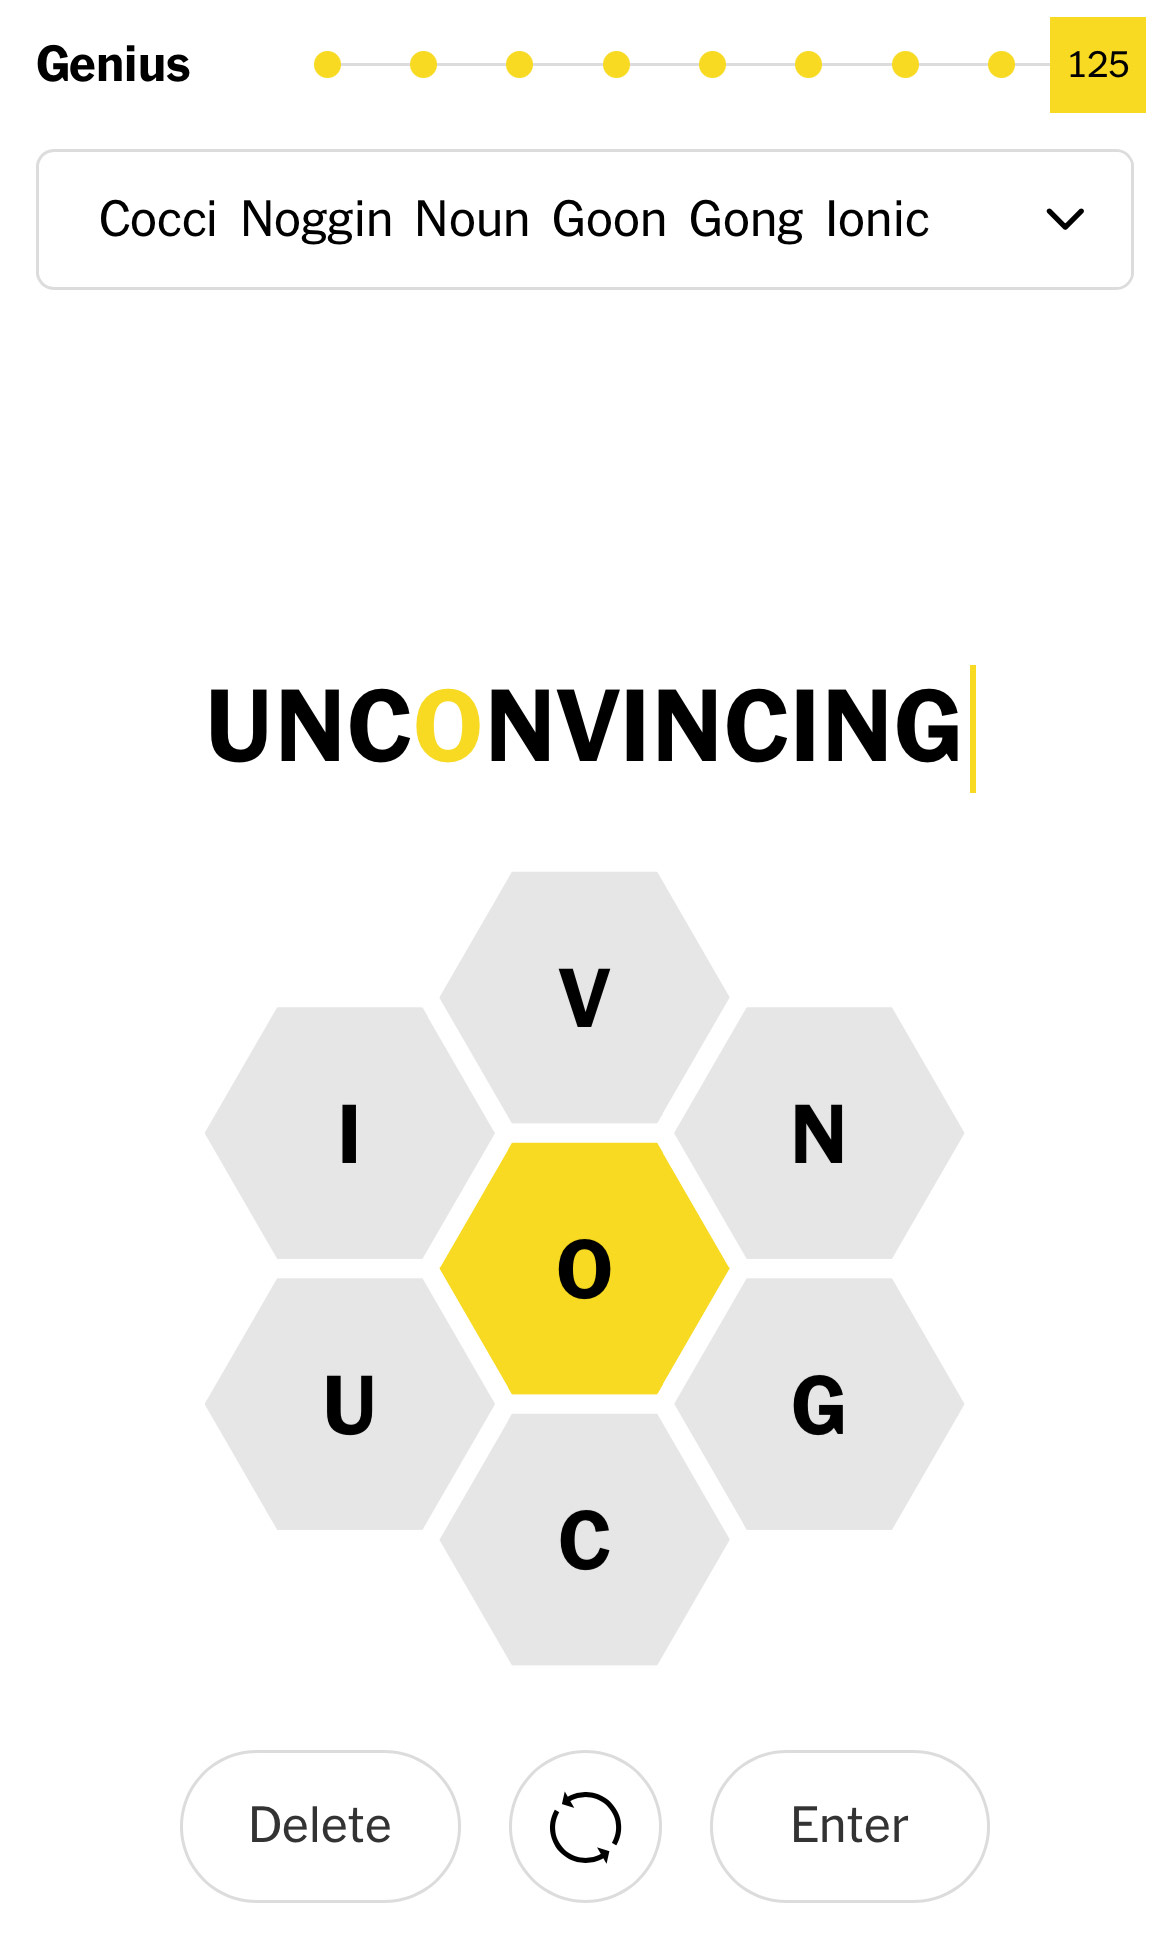

In [14]:
from IPython.display import Image
Image(filename="game_example.jpg", width=300)

___

### Inspect MacOS Word List

In [1]:
# word list of 4+ words
with open('web2.txt', 'r') as f:
    words = [x for x in f.read().split('\n') if len(x)>3]
    print('Sample 1:', words[0:5])
    print('Sample 2:', words[500:508])
    print('Sample 3:', words[5000:5008])
    f.close()

Sample 1: ['aalii', 'Aani', 'aardvark', 'aardwolf', 'Aaron']
Sample 2: ['absently', 'absentment', 'absentmindedly', 'absentness', 'absfarad', 'abshenry', 'Absi', 'absinthe']
Sample 3: ['Aleurodes', 'Aleurodidae', 'aleuromancy', 'aleurometer', 'aleuronat', 'aleurone', 'aleuronic', 'aleuroscope']


We'll want to remove capital letters, but outside of this the list appears to be all set. Some of the words seem like they may not be words in the English language. We'll cross reference the final list using a Webster Dictionary API. 

___

### Import Required Packages
- Effort was made to keep the import list lightweight

In [2]:
import warnings
import string
import ast
import os 
from dotenv import load_dotenv
import requests
import json

### Create Class

In [39]:
class SpellingBee:
    
    # Assign variables on instantiation
    def __init__(self, letters, center_letter, api_key=None, word_list=None, min_length=4):
        
        # Assign letters, letters_list, not_letters_list, center_letter, api_key
        if isinstance(letters, str):
            letters_list = [x for x in list(letters) if x.isalpha() and x.islower()]
            if len(letters_list)==7:
                self.letters = letters
                self.letters_list = letters_list
                self.not_letters_list = (set(string.ascii_lowercase) - set(letters_list))
                self.center_letter = center_letter
                self.api_key = api_key
            else:
                raise Exception('Provided string must only contain a-z and be length=7')
        else:
            raise Exception('Provided string must be in "abcdefg" format')
            
        # Assign word_list
        if word_list:
            self.word_list = word_list
            warnings.warn('Warning: Custom list being used. Ensure elements meet desired length and format requirements.')
        else:
            try: 
                with open('web2.txt', 'r') as f:
                    self.word_list = [x for x in f.read().split('\n') if len(x)>=min_length and x.islower()]
                    f.close()
            except Exception as e:
                raise e
                
    def dictionary_check(self, word):
        # URL and request
        url = f'https://dictionaryapi.com/api/v3/references/collegiate/json/{word}?key={self.api_key}' 
        r = requests.get(url)
        
        # Convert response to list
        resp_list = json.loads(r.content)
        
        # Based on structure & manual testing, if resp_list[0]['meta']['id'] is present, then the word 
        # should be acceptable in NYT
        try:
            if resp_list[0]['meta']['id']:
                return True
        except:
            return False

    def remove_letters(self):
        
        # Convert word list to string representation
        string_word_list = str(self.word_list)
        
        # Remove characters that cannot be used
        for char in self.not_letters_list:
            string_word_list = string_word_list.replace(char, '')
        
        # Initial pruned word list
        pruned_word_list = ast.literal_eval(string_word_list)
        
        # Remove words that do no contain center letter
        pruned_word_list = [word for word in pruned_word_list if self.center_letter in word]
        
        return pruned_word_list
    
    def matching_words(self):
        
        # Matching words will be the intersection of pruned list and word list
        matches = list(set(self.remove_letters()).intersection(set(self.word_list)))
        sorted_matches = sorted(matches, key=lambda x: -1*len(x))
        
        return sorted_matches
    
    def verified_matching_words(self):
        
        # Verify sorted matches against webster api; if the API returns a populated list then the word is a match 
        verified_matches = [match for match in self.matching_words() if self.dictionary_check(match)]
        
        return verified_matches

### Run w/ Daily Letters

In [40]:
%%time
load_dotenv()

# Access environment variables
api_key = os.environ['API_KEY']

# Instantiate class object with daily word list and api key
bee = SpellingBee('vinoucg', 'o', api_key)

# Check for verified matching words
print('VERIFIED:\n')
print(bee.verified_matching_words())
print('\n\n')

# Compare list to non-verified matching words
print('UNVERIFIED:\n')
print(bee.matching_words())
print('\n\n')

VERIFIED:

['unconvincing', 'convincing', 'unvoicing', 'nonunion', 'nooning', 'voicing', 'nogging', 'cogging', 'conning', 'ongoing', 'coining', 'cooing', 'nuncio', 'cocoon', 'coving', 'iconic', 'congou', 'noggin', 'ninon', 'incog', 'conic', 'going', 'coign', 'cocci', 'cogon', 'onion', 'ionic', 'union', 'inion', 'unco', 'conn', 'coco', 'icon', 'coon', 'coin', 'gong', 'goon', 'vino', 'gogo', 'noun', 'noon']



UNVERIFIED:

['unconvincing', 'unconniving', 'gonococcic', 'convincing', 'unvoicing', 'nonunion', 'unionic', 'nooning', 'voicing', 'nogging', 'cogging', 'conning', 'ingoing', 'ongoing', 'inconnu', 'coining', 'gunong', 'cooing', 'nuncio', 'novcic', 'cocoon', 'uncoin', 'coving', 'iconic', 'nonion', 'gonion', 'noncon', 'congou', 'nonoic', 'noggin', 'ninon', 'oncin', 'incog', 'conic', 'nonic', 'conin', 'going', 'covin', 'coign', 'cocci', 'cogon', 'onion', 'cocco', 'ionic', 'union', 'inion', 'unco', 'conn', 'coco', 'icon', 'coon', 'coin', 'niog', 'gong', 'unio', 'goon', 'cion', 'vino', 

___

### Notes

Interestingly, many verified words are not acceptable answers in NYT Spelling Bee, meaning that NYT uses yet another dictionary as its game basis. Webster API offers elementary dictionaries in addition to the collegiate API used here, so it's possible that other APIs would work more effectively. But instead of going down that rabbit hole we'll stop here since this code works effectively with minimal errors.

___